In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [27]:
(X_train, y_train), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

In [28]:
X_train = (X_train - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=-1)
X_train.shape

(60000, 28, 28, 1)

In [29]:
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(60000).batch(256)

Make Generator

-> (100, ) shape를 갖는 난수를 28, 28, 1 형태의 이미지로 Up-sampling

In [30]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7 * 7 * 256, input_shape = (100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, 5, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, 5, 2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, 5, 2, activation='tanh', padding='same'))

    return model

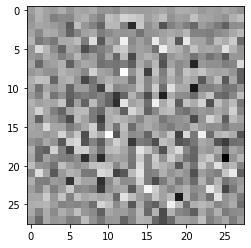

In [32]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Make Discriminator

-> Generator가 생성해낸 이미지와 진짜 이미지를 판별

In [33]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, 5, 2, padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, 5, 2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    
    # Binary Classification 필요 -> 진짜인지 가짜인지 판별
    model.add(layers.Dense(1))

    return model

In [34]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)

decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00196771]], dtype=float32)>

Define loss function, optimizers

In [35]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Generator loss function, Discriminator loss function

In [36]:
def discriminator_loss(real_output, fake_output):
    real_loss = loss_fn(tf.ones_like(real_output), real_output)
    fake_loss = loss_fn(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [37]:
def generator_loss(fake_output):
    # 이 때, generator의 입력으로는 discriminator를 거친 확률이 입력된다.
    return loss_fn(tf.ones_like(fake_output), fake_output)

In [38]:
discriminator_optimizer = tf.keras.optimizers.Adam()
generator_optimizer = tf.keras.optimizers.Adam()

Define training loop

1. 정규분포에서 랜덤값을 샘플링
2. 랜덤값을 통해 이미지를 생성
3. Discriminator를 통해 생성된 이미지를 분류
4. loss를 계산 후 D, G를 업데이트

In [51]:
epochs = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

seed.shape

TensorShape([16, 100])

In [44]:
@tf.function
def train_step(images):
    noise = tf.random.normal([256, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # step 1 . Image generate
        generated_images = generator(noise, training=True)

        # step 2 . Image classification by discriminator
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # step 3 . Calculate loss
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # step 4 . Calculate gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # step 5 . Update optimizer
    discriminator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    generator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [45]:
import time

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

train(train_dataset, 50)
print('Done.')

Done.


In [47]:
predicted_images = generator(seed)

predicted_images.shape

TensorShape([16, 28, 28, 1])

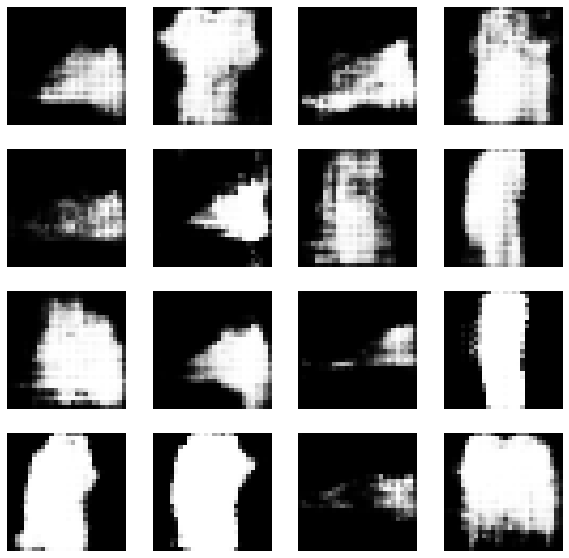

In [53]:
plt.figure(figsize=(10, 10))

for i, image in enumerate(predicted_images):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image[:, :, 0], cmap='gray')
    plt.axis("off")